In [1]:
import pickle

In [2]:
from matplotlib import pyplot as plt

In [52]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.metrics import mean_squared_error as mse
# from sklearn.metrics import auc
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
# from sklearn.neural_network import MLPRegressor
# from xgboost import XGBRegressor
from scipy.stats import entropy
import warnings
import pickle

# from causalml.inference.meta import (
#     BaseXRegressor,
#     BaseRRegressor,
#     BaseSRegressor,
#     BaseTRegressor,
# )
# from causalml.propensity import ElasticNetPropensityModel
# from causalml.dataset import simulate_nuisance_and_easy_treatment

# from MyRegressor import *
import os

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

KEY_GENERATED_DATA = "generated_data"
KEY_ACTUAL = "Actuals"

RANDOM_SEED = 42
LOAD_DATA = False

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def distr_plot_single_sim(
    synthetic_preds,
    savepath,
    kind="kde",
    include_learners=[],
    bins=50,
    histtype="step",
    alpha=1,
    linewidth=1,
    bw_method=1,
):
    """Plots the distribution of each learner's predictions (for a single simulation).
    Kernel Density Estimation (kde) and actual histogram plots supported.
    Args:
        synthetic_preds (dict): dictionary of predictions generated by get_synthetic_preds()
        kind (str, optional): 'kde' or 'hist'
        drop_learners (list, optional): list of learners (str) to omit when plotting
        bins (int, optional): number of bins to plot if kind set to 'hist'
        histtype (str, optional): histogram type if kind set to 'hist'
        alpha (float, optional): alpha (transparency) for plotting
        linewidth (int, optional): line width for plotting
        bw_method (float, optional): parameter for kde
    """
    
    learners = include_learners
    preds_for_plot = {}
    for l in learners:
        preds_for_plot[l] = synthetic_preds[l]
    
    # deleted generated data and assign actual value
    del preds_for_plot[KEY_GENERATED_DATA]
    global_lower = np.percentile(np.hstack(preds_for_plot.values()), 1)
    global_upper = np.percentile(np.hstack(preds_for_plot.values()), 99)

    # Plotting
    plt.figure(figsize=(12, 8))
    cmap = get_cmap(len(learners))
    for i, (k, v) in enumerate(preds_for_plot.items()):
        if k in learners:
            if kind == "kde":
                v = pd.Series(v.flatten())
                v = v[v.between(global_lower, global_upper)]
                v.plot(
                    kind="kde",
                    bw_method=bw_method,
                    label=k,
                    linewidth=linewidth,
                    color=cmap(i),
                )
            elif kind == "hist":
                plt.hist(
                    v,
                    bins=np.linspace(global_lower, global_upper, bins),
                    label=k,
                    histtype=histtype,
                    alpha=alpha,
                    linewidth=linewidth,
                    color=cmap(i),
                )
            else:
                pass

    plt.xlim(global_lower, global_upper)
    #plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.title("Distribution from a Single Simulation")
    plt.savefig(savepath)

def plot_dist(dictionary, linear_models, save_path, alpha = 0.2, bins = 30):
    plt.figure(figsize=(12,8))
    keys = dictionary.keys()
    lin_models = linear_models
    not_lin_models = [key for key in keys if key not in linear_models]
    for k in not_lin_models:
        values = dictionary[k]
        plt.hist(values, alpha = alpha, bins = bins, label = k, range=[-0.5, 2])
    for k in lin_models:
        values = dictionary[k]
        plt.axvline(values[0], label=k,
           linestyle='dotted', color=np.random.rand(3,), linewidth=2)
    plt.title('Distribution of CATE Predictions by Meta Learner')
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    plt.legend(fontsize=12)
    plt.savefig(save_path)

def scatter_plot_summary(synthetic_summary, savepath, k, drop_learners=[], drop_cols=[]):
    """Generates a scatter plot comparing learner performance. Each learner's performance is plotted as a point in the
    (Abs % Error of ATE, MSE) space.
    Args:
        synthetic_summary (pd.DataFrame): summary generated by get_synthetic_summary()
        k (int): number of simulations (used only for plot title text)
        drop_learners (list, optional): list of learners (str) to omit when plotting
        drop_cols (list, optional): list of metrics (str) to omit when plotting
    """
    plot_data = synthetic_summary.drop(drop_learners).drop(drop_cols, axis=1)

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    xs = plot_data["Abs % Error of ATE"]
    ys = plot_data["MSE"]

    ax.scatter(xs, ys)

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    for i, txt in enumerate(plot_data.index):
        ax.annotate(
            txt,
            (
                xs[i] - np.random.binomial(1, 0.5) * xlim[1] * 0.04,
                ys[i] - ylim[1] * 0.03,
            ),
        )

    ax.set_xlabel("Abs % Error of ATE")
    ax.set_ylabel("MSE")
    ax.set_title("Learner Performance (averaged over k={} simulations)".format(k))
    plt.savefig(savepath)

def scatter_plot_summary_holdout(
    train_summary,
    validation_summary,
    k,
    savepath,
    label=["Train", "Validation"],
    drop_learners=[],
    drop_cols=[],
):
    """Generates a scatter plot comparing learner performance by training and validation.
    Args:
        train_summary (pd.DataFrame): summary for training synthetic data generated by get_synthetic_summary_holdout()
        validation_summary (pd.DataFrame): summary for validation synthetic data generated by
            get_synthetic_summary_holdout()
        label (string, optional): legend label for plot
        k (int): number of simulations (used only for plot title text)
        drop_learners (list, optional): list of learners (str) to omit when plotting
        drop_cols (list, optional): list of metrics (str) to omit when plotting
    """
    train_summary = train_summary.drop(drop_learners).drop(drop_cols, axis=1)
    validation_summary = validation_summary.drop(drop_learners).drop(drop_cols, axis=1)

    plot_data = pd.concat([train_summary, validation_summary])
    plot_data["label"] = [i.replace("Train", "") for i in plot_data.index]
    plot_data["label"] = [i.replace("Validation", "") for i in plot_data.label]

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    xs = plot_data["Abs % Error of ATE"]
    ys = plot_data["MSE"]
    group = np.array(
        [label[0]] * train_summary.shape[0] + [label[1]] * validation_summary.shape[0]
    )
    cdict = {label[0]: "red", label[1]: "blue"}

    for g in np.unique(group):
        ix = np.where(group == g)[0].tolist()
        ax.scatter(xs[ix], ys[ix], c=cdict[g], label=g, s=100)

    for i, txt in enumerate(plot_data.label[:10]):
        ax.annotate(txt, (xs[i] + 0.005, ys[i]))

    ax.set_xlabel("Abs % Error of ATE")
    ax.set_ylabel("MSE")
    ax.set_title("Learner Performance (averaged over k={} simulations)".format(k))
    ax.legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
    plt.savefig(savepath)

def bar_plot_summary_holdout(
    train_summary, validation_summary, k, savepath, drop_learners=[], drop_cols=[]
):
    """Generates a bar plot comparing learner performance by training and validation
    Args:
        train_summary (pd.DataFrame): summary for training synthetic data generated by get_synthetic_summary_holdout()
        validation_summary (pd.DataFrame): summary for validation synthetic data generated by
            get_synthetic_summary_holdout()
        k (int): number of simulations (used only for plot title text)
        drop_learners (list, optional): list of learners (str) to omit when plotting
        drop_cols (list, optional): list of metrics (str) to omit when plotting
    """
    train_summary = train_summary.drop([KEY_ACTUAL])
    train_summary["Learner"] = train_summary.index

    validation_summary = validation_summary.drop([KEY_ACTUAL])
    validation_summary["Learner"] = validation_summary.index

    for metric in ["Abs % Error of ATE", "MSE", "KL Divergence"]:
        plot_data_sub = pd.DataFrame(train_summary.Learner).reset_index(drop=True)
        plot_data_sub["train"] = train_summary[metric].values
        plot_data_sub["validation"] = validation_summary[metric].values
        plot_data_sub = plot_data_sub.set_index("Learner")
        plot_data_sub = plot_data_sub.drop(drop_learners).drop(drop_cols, axis=1)
        plot_data_sub = plot_data_sub.sort_values("train", ascending=True)

        plot_data_sub.plot(kind="bar", color=["red", "blue"], figsize=(12, 8))
        plt.xticks(rotation=30)
        plt.title(
            "Learner Performance of {} (averaged over k={} simulations)".format(
                metric, k
            )
        )
        plt.savefig(savepath)


In [53]:
with open('preds_dict_valid.pkl', 'rb') as handle:
    preds_dict_valid = pickle.load(handle)


In [54]:
preds_dict_valid.keys()

dict_keys(['Actuals', 'generated_data', 'S Learner (LR)', 'S Learner (XGB)', 'S Learner (SVR)', 'S Learner (Decision_Tree)', 'S Learner (MLP)', 'S Learner (Bagging_LR)', 'S Learner (Bagging_SVR)', 'S Learner (Bagging_DT)', 'S Learner (Bagging_MLP)', 'S Learner (Adaboost_LR)', 'S Learner (Adaboost_SVR)', 'S Learner (Adaboost_DT)', 'S Learner (Adaboost_MLP)', 'S Learner (Random_Forest)', 'T Learner (LR)', 'T Learner (XGB)', 'T Learner (SVR)', 'T Learner (Decision_Tree)', 'T Learner (MLP)', 'T Learner (Bagging_LR)', 'T Learner (Bagging_SVR)', 'T Learner (Bagging_DT)', 'T Learner (Bagging_MLP)', 'T Learner (Adaboost_LR)', 'T Learner (Adaboost_SVR)', 'T Learner (Adaboost_DT)', 'T Learner (Adaboost_MLP)', 'T Learner (Random_Forest)', 'X Learner (LR)', 'X Learner (XGB)', 'X Learner (SVR)', 'X Learner (Decision_Tree)', 'X Learner (MLP)', 'X Learner (Bagging_LR)', 'X Learner (Bagging_SVR)', 'X Learner (Bagging_DT)', 'X Learner (Bagging_MLP)', 'X Learner (Adaboost_LR)', 'X Learner (Adaboost_SVR)

In [58]:
include_learners = [s for s in preds_dict_valid.keys() if '(LR)' in s and "S Learner" not in s]
include_learners

['T Learner (LR)', 'X Learner (LR)']

In [56]:
include_learners = [
    ''
]

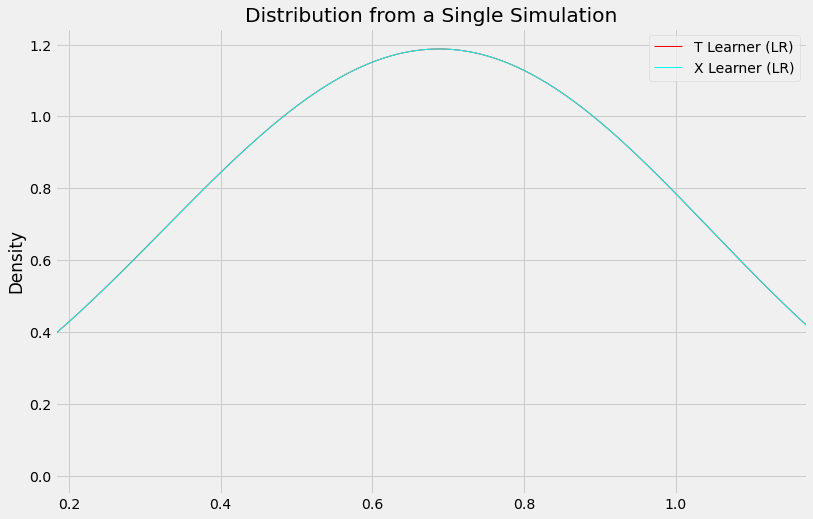

In [59]:
distr_plot_single_sim(
    synthetic_preds = preds_dict_valid,
    savepath = 'asdf.png',
    include_learners = include_learners + ['generated_data']
)